# Usage of trained U-Net
Application of frames of a video and display of results.

## General remarks
The general process looks as following:

Load video -> Extract Frame(s if Batch Processing) -> rescale input to [0,1] -> apply model (+sigmoid on first output) -> "renormalize" -> post process -> output for all 

### Important notes:
- The input model should be a pytorch tensor of the form [batch_size, 1, image_width, image_height]
- The model outputs for every input image 7 output "channels":
    - ["Detection Map", "Y Offset", "X Offset", "BG Intensity", "Img Intensity", "Radial Defocus", "Ellipsoidal Distortion"]
    - Hence, the output is of form [batch_size, 7, image_width, image_height]
    - The Detection map contains Gaussian Kernels where the model predicts a particle

### Post Processing
- First, in the Detection Map the maxima are searched (a threshold value for detection can be set)
- at those positions, the other maps are read and stored for every particle. The position is added to Y and X Pos for direct readout
- the final output is a list of size [num_frames] containing for each frame all particles with all information in the following order ["Detection Certainty", "Y Pos", "X Pos", "BG Intensity", "Img Intensity", "Radial Defocus", "Ellipsoidal Distortion"]

In [1]:
from model.flex_unet import UNet
import torch.nn as nn
import torch
import json
from utils import post_processing as pp
from utils import plot_results as pr
from utils import io
import time
import numpy as np
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Check if GPU is available
print(device)

/usr/users/fseel/miniconda3/envs/pytorch_cuda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


## Load Parameters
In order to "load" the model as it was trained, we need some architecture information ("setup parameters"), the weights of the model and the normalizing parameters used before and after applying the model.

The parameter for the input might be adjusted depending on your video / reader, the resulting values should be in [0,1].
For the output standard deviations and means, it is generally not recommended to change the values as these are the values used in the training (an exception might be the first output if you desire to furthe "post process" the resulting gaussian estimation of the centers of droplets).

In [2]:
setup_file="model/setup_parameters.json"
weight_file="model/weights"
normalizing_file = "model/normalizing_parameters.json"

with open(setup_file, "r") as file:
    setup_parameters = json.load(file)
with open(normalizing_file, "r") as file:
    normalizing_parameters = json.load(file)

input_mean = normalizing_parameters['input_mean'] # Change to your values
input_std = normalizing_parameters['input_std']

stds = torch.tensor(normalizing_parameters['output_stds']).reshape(len(normalizing_parameters['output_stds']),1,1).to(device)
means = torch.tensor(normalizing_parameters['output_means']).reshape(len(normalizing_parameters['output_means']),1,1).to(device)

result_labels=setup_parameters['out_channels']

## Setup Model
Using the loaded parameters and weights, let's set up the model.

In [3]:
model = UNet(in_channels=setup_parameters['in_channels'],
             n_classes=len(setup_parameters['out_channels']),
             depth=setup_parameters['depth'],
             wf=setup_parameters['wf'],
             padding=setup_parameters['padding'],
             batch_norm=setup_parameters['batch_norm'],
             dropout=setup_parameters['dropout'],
             up_mode=setup_parameters['up_mode'])
model = nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(torch.load(weight_file, map_location=device))

<All keys matched successfully>

## Load Video

In [4]:
vid_path = "/usr/users/agecker/datasets/particle_tracking/raw/20190928_exp105.cam2.mkv" # replace with path to one of your videos

vid = io.open_video(vid_path)

meta = vid.get_meta_data()
nframes = round(meta["duration"]*meta["fps"])

## Process video
Here, we apply the model frame by frame.
Additionally, some post processing steps are needed to get the output in the desired form.
The model expects as input a torch tensor of the form [batch_size, 1, width, height].
(Note: a higher batch_size probably won't help much with the framerate, as the postprocessing is currently not parallelized and hence the bottleneck).
The "mysterious" 1 in the shape refers to the fact that we use only one color channel as the video is black and white.

In [5]:
vid.set_image_index(0)
all_results=[]
total_time=0
batch_size=8 # If you get "CUDA out of memory error", try decreasing the batch size. Increase for (slightly) better performance
with torch.no_grad():
    with torch.cuda.amp.autocast():
        for i in range(math.ceil(nframes/batch_size)):
            t1=time.time()

            imgs_in_batch = min(batch_size, nframes-i*batch_size)
            
            images=[]
            for j in range(imgs_in_batch):
                images.append(vid.get_next_data()[:,:,0])

            input = torch.from_numpy(np.array(images)).reshape(imgs_in_batch,1,*images[0].shape).to(torch.half).to(device) # half precision to use less memory
            input = ((input-input_mean)/input_std)

            output = model(input)
            output[:,0]= torch.sigmoid(output[:,0]) # For output 0, a sigmoid needs to be applied in the end.

            output = output*stds+means # Renormalize
            maxima = pp.peak_local_max(output[:,0], threshold_abs=0.01) # Since the values are stored, we can use a low threshold here and if needed refine our choice in the final output

            # get it to the cpu
            output = output.cpu().numpy()
            maxima = maxima.cpu().numpy()

            # "Annotate" with dimension names etc
            
            for j in range(imgs_in_batch):
                indices=maxima[j].nonzero() # get the sensor coordinates of the maxima
                results=output[j,0:,indices[0],indices[1]]

                results[:,1] += indices[0] # combine offsets and sensor coordinates
                results[:,2] += indices[1] # combine offsets and sensor coordinates
                all_results.append(results.T)
            
            t2=time.time()
            total_time += t2-t1
            print('Progress: {:.2%} - Current FPS: {:.2f} / Avg FPS: {:.2f}\t\t\t'.format(min(((i+1.0)*batch_size)/nframes,1), imgs_in_batch/(t2-t1), (i+1)*batch_size/total_time), end='\r')

# Update the result labels, as we changed from offset to actual sensor coordinates
result_labels[1]="Y Position"
result_labels[1]="X Position"

## Show results
Just for convenience: Let's have a look at the results, or at least one frame.
Let's first have a look at the result labels and the corresponding channel numbers:

In [11]:
print(*[str(channel_no) + ": " + label +", " for channel_no, label in enumerate(result_labels)])

0: Detection Certainty,  1: X Position,  2: X Offset,  3: BG Intensity,  4: Img Intensity,  5: Radial Defocus,  6: Ellipsoidal Distortion, 


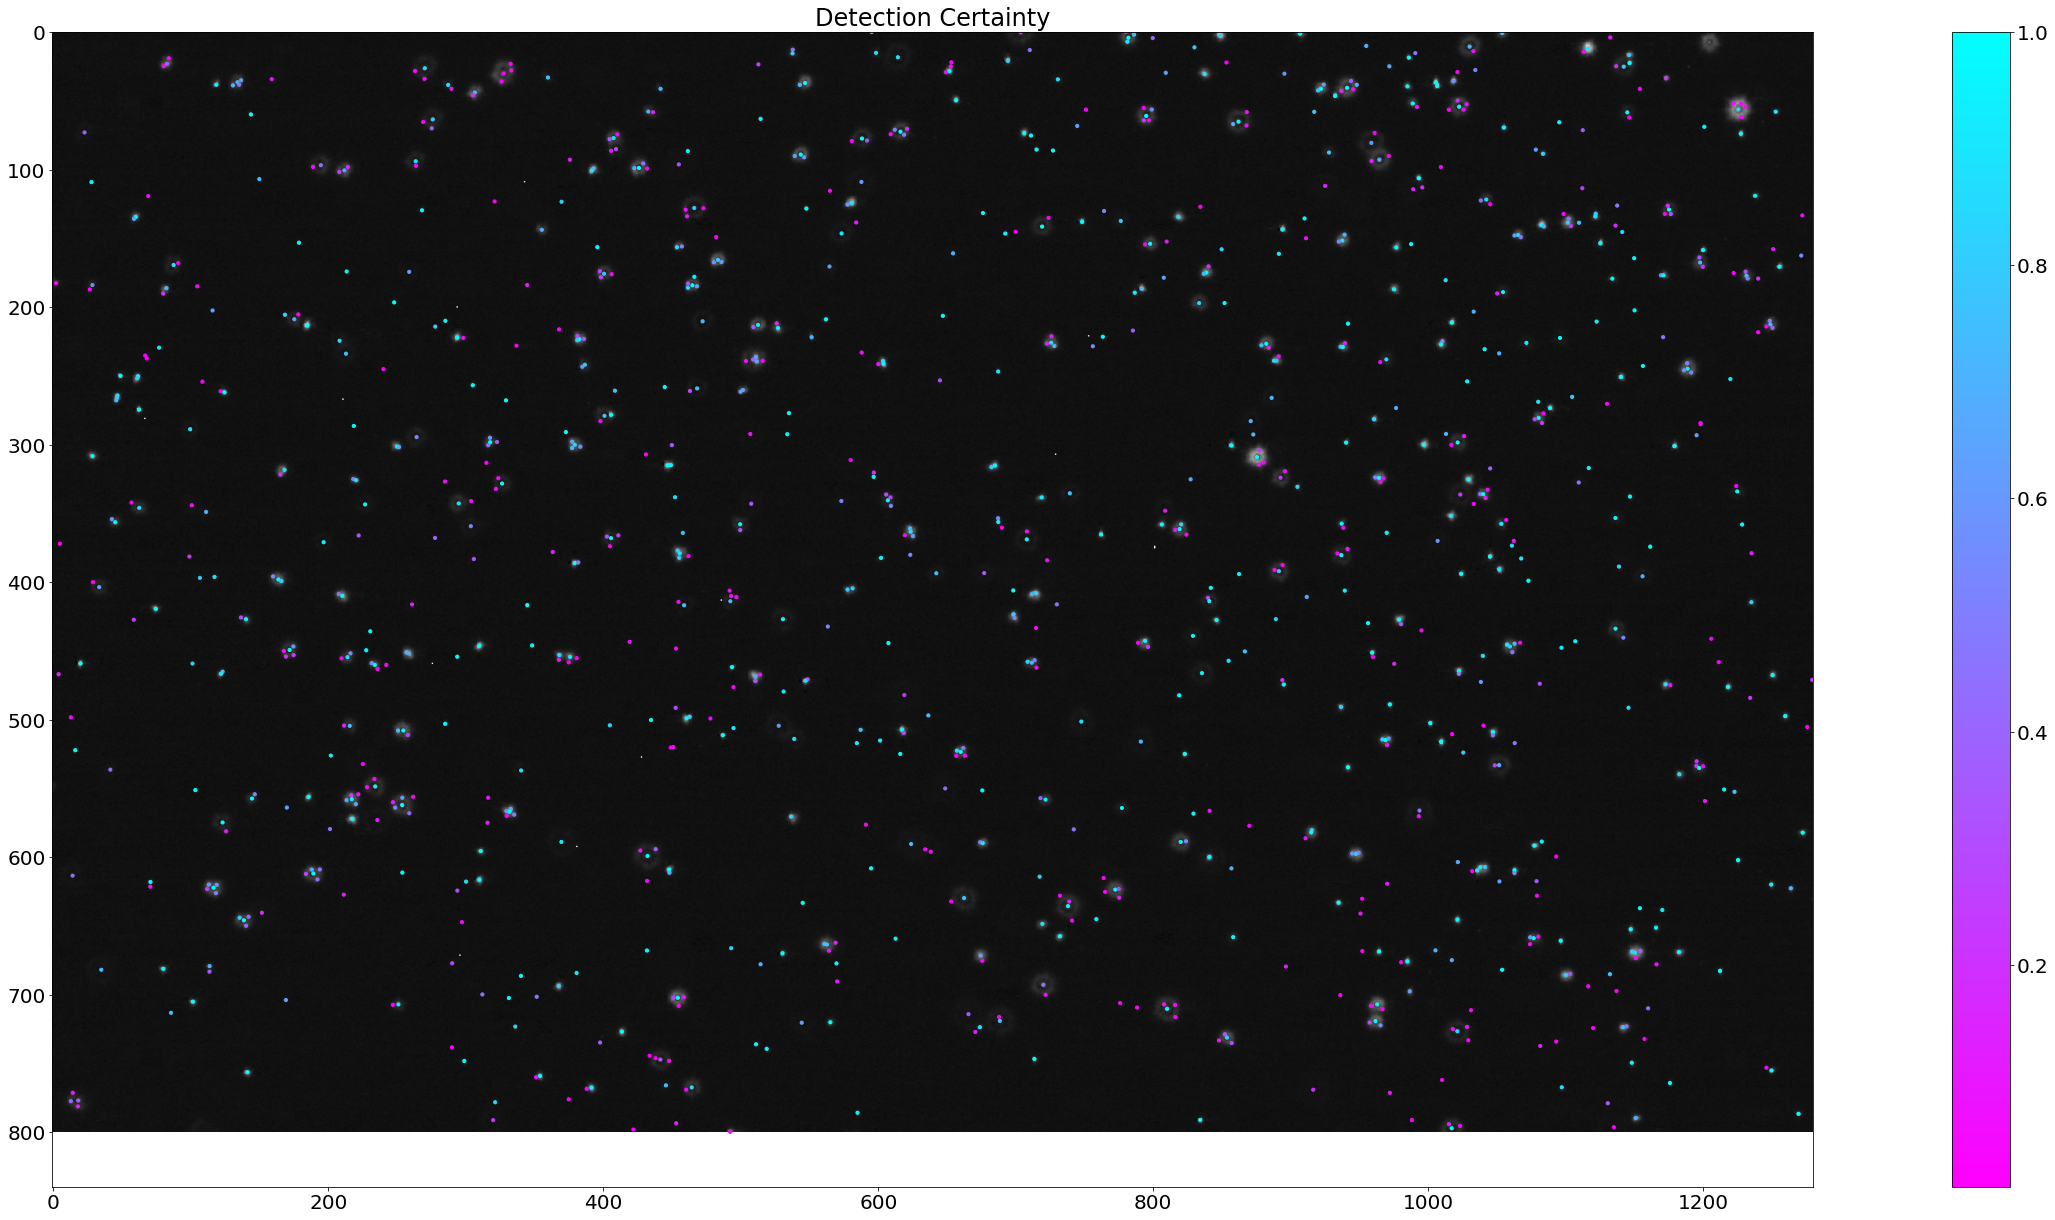

In [6]:
pr.show(vid, all_results, img_no=1, channel=0, result_labels=result_labels)